In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tqdm

# Import v2 modules with abbreviated names
import src.data_management_v2 as dm
from src.structure_manager_v2 import StructureManager
import src.rdf_v2 as rdf
import src.ensembles_v2 as ens
import src.Birch_Murnaghan2 as bm
import src.entropy as ent
import quests

# Set random seed for reproducibility
np.random.seed(42)

folder_path = "data/all_sizes"
vasp24 = [f for f in os.listdir(folder_path) if f.startswith('SiO2_24')]
vasp36 = [f for f in os.listdir(folder_path) if f.startswith('SiO2_36')]
vasp48 = [f for f in os.listdir(folder_path) if f.startswith('SiO2_48')]
vaspall = [f for f in os.listdir(folder_path) if f.startswith('SiO2')]
struct_ids = [f.replace('.vasp', '') for f in vaspall]
struct_ids_24 = [f.replace('.vasp', '') for f in vasp24]
struct_ids_36 = [f.replace('.vasp', '') for f in vasp36]
struct_ids_48 = [f.replace('.vasp', '') for f in vasp48]

struct_ids_36.sort()
struct_ids_24.sort()
struct_ids_48.sort()
struct_ids.sort()   

In [10]:
def filter_cubic_structures(struct_ids, angle_min=85, angle_max=95):
    """
    Filter structures with nearly cubic cell angles.
    
    Parameters:
    -----------
    struct_ids : list
        List of structure IDs (e.g., 'SiO2_36_00001')
    angle_min : float
        Minimum angle in degrees (default 85)
    angle_max : float
        Maximum angle in degrees (default 95)
        
    Returns:
    --------
    list : Filtered structure IDs
    """
    # Load all structures
    structures = dm.load_structures(struct_ids)
    
    cubic_ids = []
    
    for struct_id, structure in structures.items():
        alpha, beta, gamma = structure.lattice.angles
        
        if (angle_min <= alpha <= angle_max and 
            angle_min <= beta <= angle_max and 
            angle_min <= gamma <= angle_max):
            cubic_ids.append(struct_id)
    
    return cubic_ids

# Example usage:
cubic_36 = filter_cubic_structures(struct_ids_36, angle_min=80, angle_max=100)
print(f"Found {len(cubic_36)} out of {len(struct_ids_36)} structures with nearly cubic cells")
cubic_24 = filter_cubic_structures(struct_ids_24, angle_min=80, angle_max=100)
print(f"Found {len(cubic_24)} out of {len(struct_ids_24)} structures with nearly cubic cells")
cubic_48 = filter_cubic_structures(struct_ids_48, angle_min=80, angle_max=100)
print(f"Found {len(cubic_48)} out of {len(struct_ids_48)} structures with nearly cubic cells")

Found 7 out of 414 structures with nearly cubic cells
Found 40 out of 2916 structures with nearly cubic cells
Found 4 out of 148 structures with nearly cubic cells


Plotting Qn distributions...


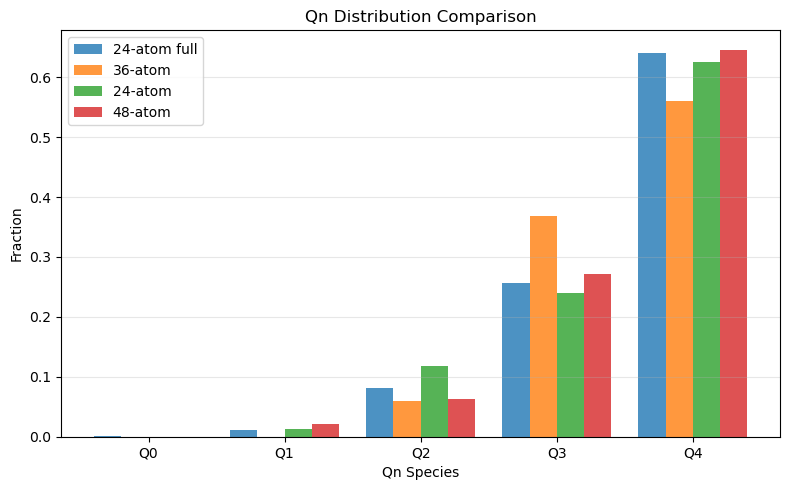

Plotting bond angle distributions...


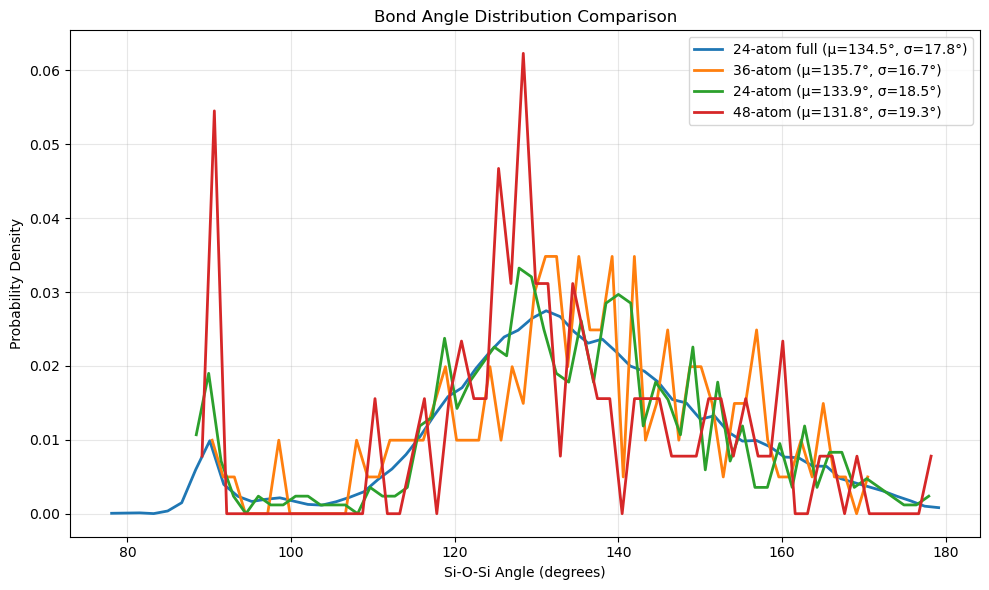

Plotting ring distributions...


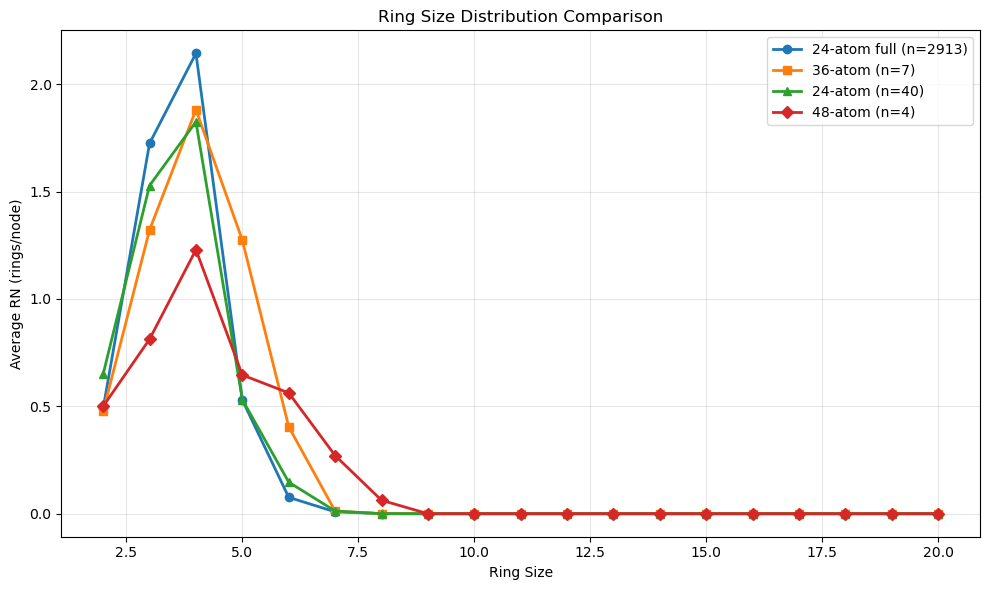

Note: To plot RDFs, use rdf_v2.plot_multiple_rdfs() separately


{'qn': [{0: np.float64(0.0007294884998283556),
   1: np.float64(0.01167181599725369),
   2: np.float64(0.08114486783384826),
   3: np.float64(0.256737040851356),
   4: np.float64(0.6403621695846207)},
  {0: np.float64(0.0),
   1: np.float64(0.0),
   2: np.float64(0.05952380952380952),
   3: np.float64(0.369047619047619),
   4: np.float64(0.5595238095238095)},
  {0: np.float64(0.0),
   1: np.float64(0.0125),
   2: np.float64(0.11875),
   3: np.float64(0.240625),
   4: np.float64(0.625)},
  {0: np.float64(0.0),
   1: np.float64(0.020833333333333332),
   2: np.float64(0.0625),
   3: np.float64(0.2708333333333333),
   4: np.float64(0.6458333333333333)}],
 'bad': [{'label': '24-atom full',
   'bin_centers': array([ 78.06121731,  79.77446777,  81.48771823,  83.20096869,
           84.91421916,  86.62746962,  88.34072008,  90.05397054,
           91.767221  ,  93.48047146,  95.19372193,  96.90697239,
           98.62022285, 100.33347331, 102.04672377, 103.75997423,
          105.4732247 , 107

In [15]:
import src.plotting_v2 as plt_v2
# Compare two datasets
# plt_v2.plot_qn_distributions(struct_ids_24, cubic_24, labels=['24-atom', 'cubic 24-atom'])
# plt_v2.plot_bond_angle_distributions(struct_ids_36, cubic_36, labels=['36-atom', 'cubic 36-atom'])
# plt_v2.plot_ring_distributions(struct_ids_48, cubic_48, labels=['48-atom', 'cubic 48-atom'])

# Or all at once
plt_v2.plot_all_metrics(struct_ids_24, cubic_36, cubic_24, cubic_48, labels=['24-atom full', '36-atom', '24-atom', '48-atom'])

Found 500 CONTCAR files


Processing CONTCARs: 100%|██████████| 500/500 [00:22<00:00, 21.96it/s]



Successfully processed 500 structures
Failed: 0


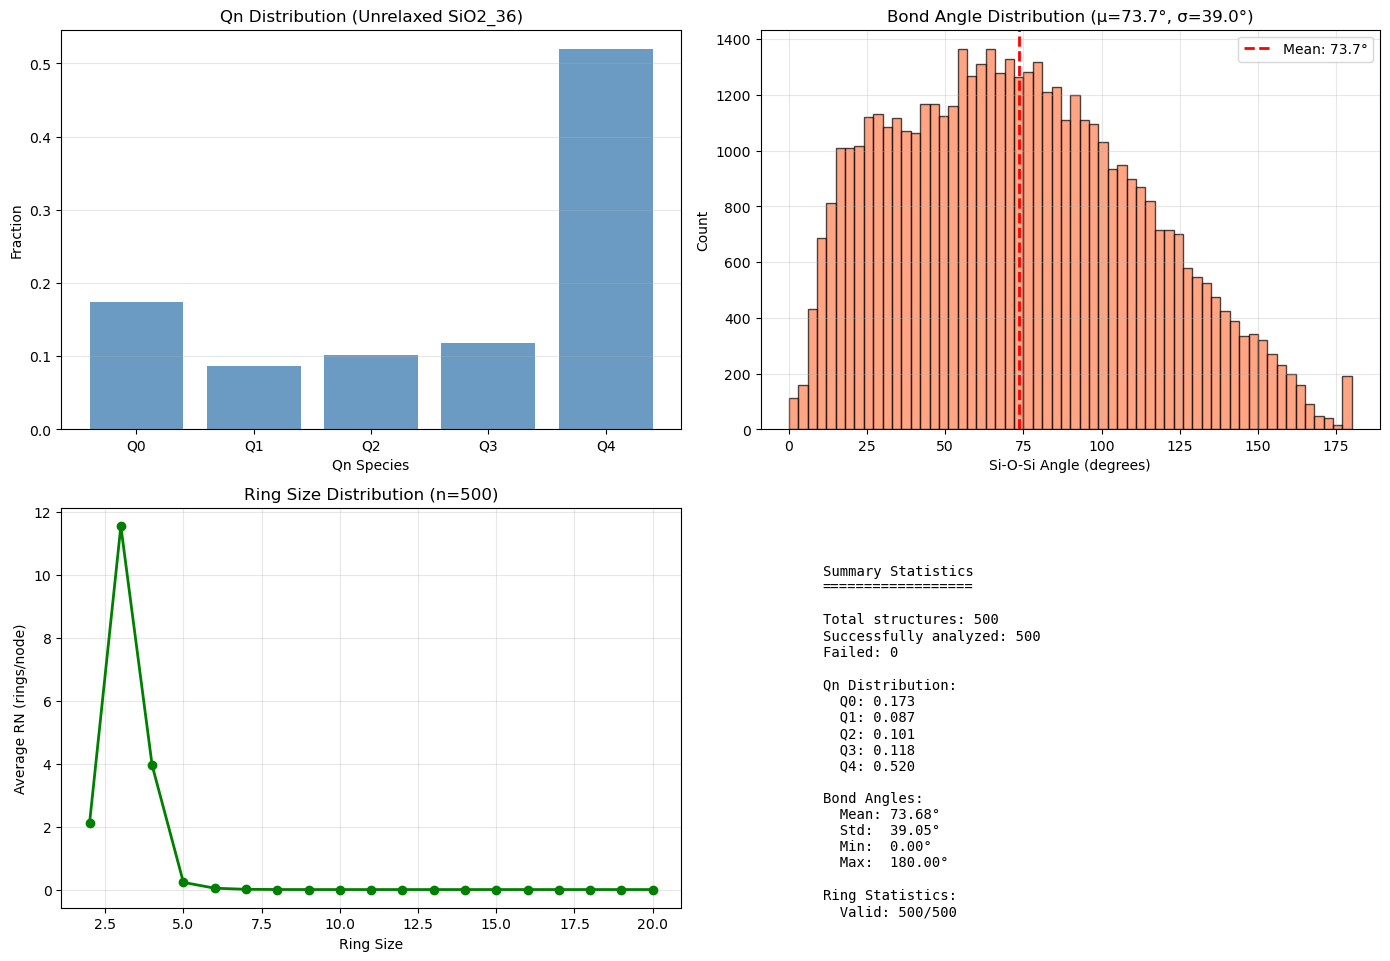


Average Qn Distribution:
  Q0: 0.1735
  Q1: 0.0870
  Q2: 0.1013
  Q3: 0.1180
  Q4: 0.5202


In [16]:
# One-off analysis for unrelaxed SiO2_36 structures
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from pymatgen.core import Structure
from pymatgen.analysis.local_env import CrystalNN
from tqdm import tqdm
import networkx as nx
from collections import defaultdict
from src.rings import calculate_ring_statistics_for_structure

# Find all CONTCAR files
base_path = "/Users/raphaelzstone/Documents/Ensemble-Analysis/data/SiO2_36"
contcar_paths = glob.glob(os.path.join(base_path, "*/CONTCAR"))
print(f"Found {len(contcar_paths)} CONTCAR files")

# Initialize storage
qn_data_all = []
bad_data_all = []
ring_stats_all = []
failed_structures = []

# Process each CONTCAR
for contcar_path in tqdm(contcar_paths, desc="Processing CONTCARs"):
    struct_id = os.path.basename(os.path.dirname(contcar_path))
    
    try:
        # Load structure
        structure = Structure.from_file(contcar_path)
        
        # ===== Qn Distribution =====
        qn_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
        
        si_indices = [i for i, site in enumerate(structure) if site.species_string == 'Si']
        
        for si_idx in si_indices:
            si_site = structure[si_idx]
            # Find oxygen neighbors (more permissive cutoff for unrelaxed)
            o_neighbors = structure.get_neighbors(si_site, 2.2)  # Increased from 2.0
            
            # Count bridging oxygens
            bridging_count = 0
            for o_neighbor in o_neighbors:
                o_idx = o_neighbor.index
                o_site = structure[o_idx]
                
                if o_site.species_string == 'O':
                    # Check if O connects to another Si
                    other_si = structure.get_neighbors(o_site, 2.2)
                    si_connected = sum(1 for n in other_si if n.index != si_idx and structure[n.index].species_string == 'Si')
                    if si_connected > 0:
                        bridging_count += 1
            
            # Cap at Q4
            qn = min(bridging_count, 4)
            qn_counts[qn] += 1
        
        # Calculate Qn fractions
        total_si = len(si_indices)
        qn_fractions = {n: qn_counts[n] / total_si if total_si > 0 else 0 for n in range(5)}
        qn_data_all.append(qn_fractions)
        
        # ===== Bond Angle Distribution =====
        angles = []
        for si_idx in si_indices:
            si_site = structure[si_idx]
            o_neighbors = structure.get_neighbors(si_site, 2.2)
            
            for o_neighbor in o_neighbors:
                o_idx = o_neighbor.index
                o_site = structure[o_idx]
                
                if o_site.species_string == 'O':
                    # Find other Si connected to this O
                    other_si = structure.get_neighbors(o_site, 2.2)
                    
                    for other_si_neighbor in other_si:
                        if other_si_neighbor.index != si_idx and structure[other_si_neighbor.index].species_string == 'Si':
                            # Calculate Si-O-Si angle
                            vec1 = si_site.coords - o_site.coords
                            vec2 = structure[other_si_neighbor.index].coords - o_site.coords
                            
                            cos_angle = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
                            cos_angle = np.clip(cos_angle, -1, 1)
                            angle = np.degrees(np.arccos(cos_angle))
                            angles.append(angle)
        
        bad_data_all.append(angles)
        
        # ===== Ring Statistics (may fail for unrelaxed) =====
        try:
            cutoffs = {
                ('Si', 'O'): 2.2,
                ('O', 'Si'): 2.2,
                ('Si', 'Si'): 3.5,
                ('O', 'O'): 3.2,
            }
            ring_stats = calculate_ring_statistics_for_structure(structure, cutoffs=cutoffs, max_ring_size=20)
            ring_stats_all.append(ring_stats)
        except:
            ring_stats_all.append(None)
            
    except Exception as e:
        failed_structures.append((struct_id, str(e)))
        continue

print(f"\nSuccessfully processed {len(qn_data_all)} structures")
print(f"Failed: {len(failed_structures)}")

# ===== PLOT RESULTS =====

# 1. Average Qn Distribution
avg_qn = {n: np.mean([qn[n] for qn in qn_data_all]) for n in range(5)}

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Qn plot
ax = axes[0, 0]
x = np.arange(5)
ax.bar(x, [avg_qn[n] for n in range(5)], alpha=0.8, color='steelblue')
ax.set_xlabel('Qn Species')
ax.set_ylabel('Fraction')
ax.set_title('Qn Distribution (Unrelaxed SiO2_36)')
ax.set_xticks(x)
ax.set_xticklabels([f'Q{n}' for n in range(5)])
ax.grid(True, alpha=0.3, axis='y')

# Bond Angle Distribution
ax = axes[0, 1]
all_angles = [angle for angles in bad_data_all for angle in angles]
ax.hist(all_angles, bins=60, alpha=0.7, color='coral', edgecolor='black')
ax.axvline(np.mean(all_angles), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(all_angles):.1f}°')
ax.set_xlabel('Si-O-Si Angle (degrees)')
ax.set_ylabel('Count')
ax.set_title(f'Bond Angle Distribution (μ={np.mean(all_angles):.1f}°, σ={np.std(all_angles):.1f}°)')
ax.legend()
ax.grid(True, alpha=0.3)

# Ring Distribution
ax = axes[1, 0]
ring_stats_valid = [r for r in ring_stats_all if r is not None]
if len(ring_stats_valid) > 0:
    ring_sizes = range(2, 21)
    avg_rn = {size: np.mean([stats['RN'].get(size, 0) for stats in ring_stats_valid]) for size in ring_sizes}
    ax.plot(list(ring_sizes), [avg_rn[s] for s in ring_sizes], 'o-', linewidth=2, markersize=6, color='green')
    ax.set_xlabel('Ring Size')
    ax.set_ylabel('Average RN (rings/node)')
    ax.set_title(f'Ring Size Distribution (n={len(ring_stats_valid)})')
    ax.grid(True, alpha=0.3)
else:
    ax.text(0.5, 0.5, 'Ring statistics failed\nfor unrelaxed structures', 
            ha='center', va='center', transform=ax.transAxes)
    ax.set_title('Ring Size Distribution')

# Summary statistics
ax = axes[1, 1]
ax.axis('off')
summary_text = f"""
Summary Statistics
==================

Total structures: {len(contcar_paths)}
Successfully analyzed: {len(qn_data_all)}
Failed: {len(failed_structures)}

Qn Distribution:
  Q0: {avg_qn[0]:.3f}
  Q1: {avg_qn[1]:.3f}
  Q2: {avg_qn[2]:.3f}
  Q3: {avg_qn[3]:.3f}
  Q4: {avg_qn[4]:.3f}

Bond Angles:
  Mean: {np.mean(all_angles):.2f}°
  Std:  {np.std(all_angles):.2f}°
  Min:  {np.min(all_angles):.2f}°
  Max:  {np.max(all_angles):.2f}°

Ring Statistics:
  Valid: {len(ring_stats_valid)}/{len(ring_stats_all)}
"""
ax.text(0.1, 0.9, summary_text, fontfamily='monospace', fontsize=10, va='top')

plt.tight_layout()
plt.show()

# Print average Qn
print("\nAverage Qn Distribution:")
for n in range(5):
    print(f"  Q{n}: {avg_qn[n]:.4f}")

Loaded structure with 1200 atoms
Si atoms: 400, O atoms: 800
Calculating ring statistics (this may take a moment for 1200 atoms)...


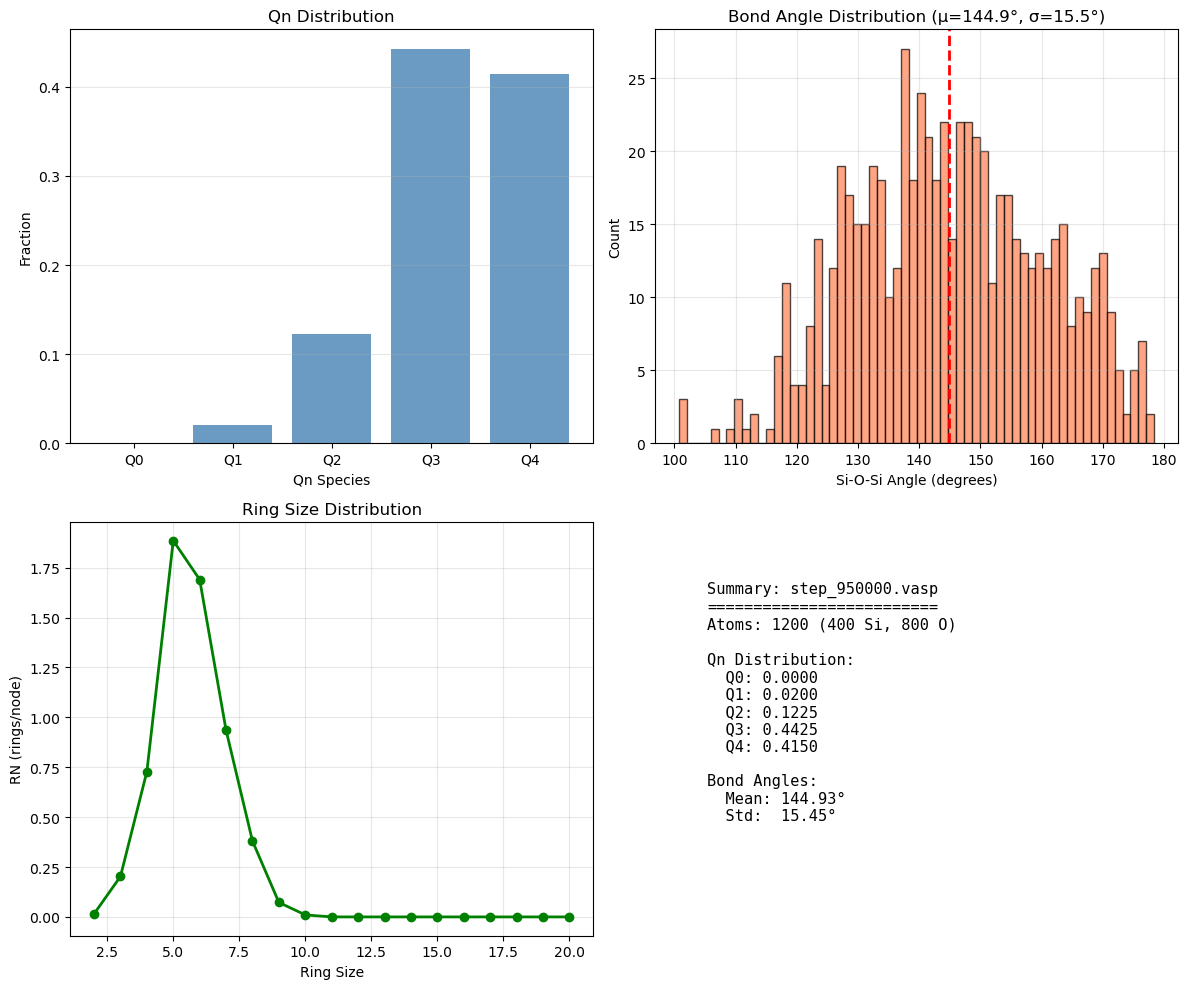

In [7]:
# One-off analysis of 1200-atom MD structure
from pymatgen.core import Structure
import numpy as np
import matplotlib.pyplot as plt
from src.rings import calculate_ring_statistics_for_structure
stepnum = 950000
# Load the structure
vasp_path = f"/Users/raphaelzstone/Documents/Ensemble-Analysis/data/SiO2_1200_vasps/step_{stepnum}.vasp"
structure = Structure.from_file(vasp_path)
print(f"Loaded structure with {len(structure)} atoms")

# Parameters
bond_threshold = 1.8

# Find Si and O indices
si_indices = [i for i, site in enumerate(structure) if site.specie.symbol == 'Si']
o_indices = [i for i, site in enumerate(structure) if site.specie.symbol == 'O']
print(f"Si atoms: {len(si_indices)}, O atoms: {len(o_indices)}")

# ===== Qn Distribution =====
qn_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}

for si_idx in si_indices:
    bonded_o = [o_idx for o_idx in o_indices if structure.get_distance(si_idx, o_idx) < bond_threshold]
    
    num_bridging = 0
    for o_idx in bonded_o:
        si_neighbors = sum(1 for other_si in si_indices if other_si != si_idx 
                          and structure.get_distance(o_idx, other_si) < bond_threshold)
        if si_neighbors >= 1:
            num_bridging += 1
    
    qn = min(num_bridging, 4)
    qn_counts[qn] += 1

qn_fractions = {n: qn_counts[n] / len(si_indices) for n in range(5)}

# ===== Bond Angle Distribution =====
angles = []
for o_idx in o_indices:
    bonded_si = [si_idx for si_idx in si_indices if structure.get_distance(o_idx, si_idx) < bond_threshold]
    
    if len(bonded_si) == 2:
        si1, si2 = bonded_si
        d1 = structure.get_distance(si1, o_idx)
        d2 = structure.get_distance(si2, o_idx)
        d12 = structure.get_distance(si1, si2)
        
        cos_angle = np.clip((d1**2 + d2**2 - d12**2) / (2 * d1 * d2), -1, 1)
        angles.append(np.degrees(np.arccos(cos_angle)))

# ===== Ring Statistics =====
print("Calculating ring statistics (this may take a moment for 1200 atoms)...")
try:
    ring_stats = calculate_ring_statistics_for_structure(structure, max_ring_size=20)
    ring_success = True
except Exception as e:
    print(f"Ring calculation failed: {e}")
    ring_success = False

# ===== PLOTTING =====
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Qn Distribution
ax = axes[0, 0]
ax.bar(range(5), [qn_fractions[n] for n in range(5)], color='steelblue', alpha=0.8)
ax.set_xlabel('Qn Species')
ax.set_ylabel('Fraction')
ax.set_title('Qn Distribution')
ax.set_xticks(range(5))
ax.set_xticklabels([f'Q{n}' for n in range(5)])
ax.grid(True, alpha=0.3, axis='y')

# Bond Angle Distribution
ax = axes[0, 1]
ax.hist(angles, bins=60, color='coral', alpha=0.7, edgecolor='black')
ax.axvline(np.mean(angles), color='red', linestyle='--', linewidth=2)
ax.set_xlabel('Si-O-Si Angle (degrees)')
ax.set_ylabel('Count')
ax.set_title(f'Bond Angle Distribution (μ={np.mean(angles):.1f}°, σ={np.std(angles):.1f}°)')
ax.grid(True, alpha=0.3)

# Ring Distribution
ax = axes[1, 0]
if ring_success:
    ring_sizes = range(2, 21)
    rn_values = [ring_stats['RN'].get(s, 0) for s in ring_sizes]
    ax.plot(list(ring_sizes), rn_values, 'o-', color='green', linewidth=2, markersize=6)
    ax.set_xlabel('Ring Size')
    ax.set_ylabel('RN (rings/node)')
    ax.set_title('Ring Size Distribution')
    ax.grid(True, alpha=0.3)
else:
    ax.text(0.5, 0.5, 'Ring statistics failed', ha='center', va='center', transform=ax.transAxes)

# Summary
ax = axes[1, 1]
ax.axis('off')
summary = f"""
Summary: step_{stepnum}.vasp
=========================
Atoms: {len(structure)} ({len(si_indices)} Si, {len(o_indices)} O)

Qn Distribution:
  Q0: {qn_fractions[0]:.4f}
  Q1: {qn_fractions[1]:.4f}
  Q2: {qn_fractions[2]:.4f}
  Q3: {qn_fractions[3]:.4f}
  Q4: {qn_fractions[4]:.4f}

Bond Angles:
  Mean: {np.mean(angles):.2f}°
  Std:  {np.std(angles):.2f}°
"""
ax.text(0.1, 0.9, summary, fontfamily='monospace', fontsize=11, va='top')

plt.tight_layout()
plt.show()
